<a href="https://colab.research.google.com/github/darkraithromb/next-platform-starter/blob/main/Mpox2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')
!pip install tensorflow_addons
!pip install tensorflow==2.12.0 tensorflow-addons==0.19.0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from vit_keras import vit
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time
from imutils import paths

# Load and preprocess images


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/50
1/1 [==============================] - 30s 30s/step - loss: 1.0497 - accuracy: 0.4400 - val_loss: 0.7324 - val_accuracy: 0.5789
Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: 0.8242 - accuracy: 0.5200 - val_loss: 0.6654 - val_accuracy: 0.6842
Epoch 3/50
1/1 [==============================] - 13s 13s/step - loss: 0.8192 - accuracy: 0.5312 - val_loss: 0.6038 - val_accuracy: 0.6842
Epoch 4/50
1/1 [==============================] - 13s 13s/step - loss: 0.6799 - accuracy: 0.6875 - val_loss: 0.5558 - val_accuracy: 0.6842
Epoch 5/50
1/1 [==============================] - 11s 11s/step - loss: 0.5729 - accuracy: 0.8400 - val_loss: 0.5175 - val_accuracy: 0.7368
Epoch 6/50
1/1 [==============================] - 14s 14s/step - loss: 0.7103 - accuracy: 0.6250 - val_loss: 0.4833 - val_accuracy: 0.7368
Epoch 7/50
1/1 [==============================] - 10s 10s/step - loss: 0.4662 - accuracy: 0.8800 - val_loss: 0.4524 - val_accuracy: 0.7895
Epoch 8/50
1/1 [===========

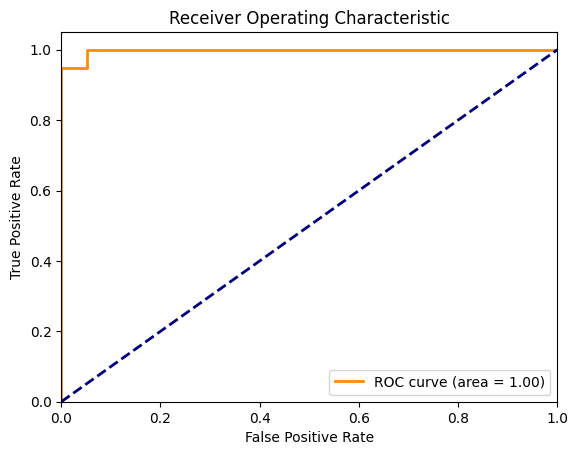

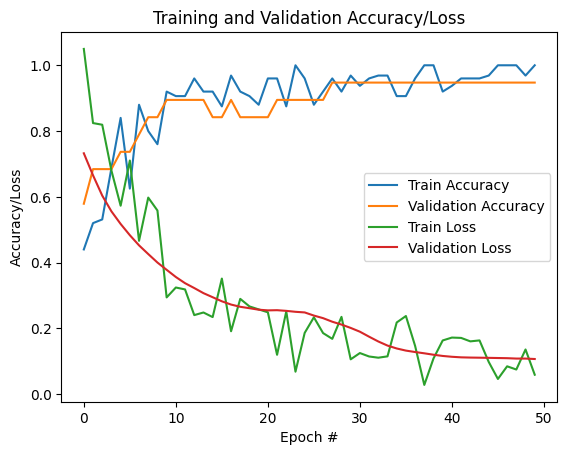

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/Monkeypox-dataset-2022-master/Monkeypox-dataset-2022-master/gray"))
data = []
labels = []

# Check if imagePaths is empty
if not imagePaths:
    print("[WARNING] No images found at the specified path.")
    exit()

# Process each image
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Resizing for Vision Transformer
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Label Binarization
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

# Data augmentation
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

# Load the Vision Transformer (ViT)
vit_model = vit.vit_b32(
    image_size=224,  # Image size for ViT
    pretrained=True,
    include_top=False,  # We will add our own top layers
    pretrained_top=False,
)

# Define the head of the model
headModel = vit_model.output
#headModel = AveragePooling2D(pool_size=(7, 7))(headModel)  # Adjust pooling size
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Create the final model
model = Model(inputs=vit_model.input, outputs=headModel)

# Freeze ViT layers
for layer in vit_model.layers:
    layer.trainable = False

# Compile the model
INIT_LR = 1e-3
EPOCHS = 50  # Adjust based on your need
BS = 32

opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Model training
# Model training
t1 = time.process_time()
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    # Remove or adjust validation_steps:
    # validation_steps=len(testX) // BS,
    epochs=EPOCHS
)
t2 = time.process_time()
print("Training time:", t2 - t1)

# Save the model weights
model.save_weights("vit_model_weights.h5")

# Evaluate the model on the test set
predIdxs = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdxs, axis=1)

# Classification report
print(classification_report(testY.argmax(axis=1), testpredict, target_names=lb.classes_))

# Confusion matrix
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(testY.ravel(), predIdxs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig('ROC_ViT', dpi=200, bbox_inches='tight')
plt.show()


# Plot training and validation accuracy/loss

plt.figure()
N = len(H.history['loss'])
plt.plot(np.arange(0, N), H.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Accuracy/Loss")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="best")
plt.savefig('Accuracy_Loss_ViT', dpi=200, bbox_inches='tight')
plt.show()